<div class="alert alert-danger">

**Refresh your knowledge of the provided classes *BayesNet* and *Variable* by reading the `BayesNet Introduction` notebook** before you start working on this problem set!
</div>

# Gibbs Sampling & Parameter Learning
## Problem Set 3 

## Probabilistic Models UE

---
In the third assignment, you will familiarise yourself with Gibbs sampling, estimate the (conditional) probability tables (i.e., parameters) of a given network structure from data, and compare the performance of different models in terms of log-likelihood.

## Submission

**Due-Date:** see Moodle
 
**Automatic Grading:** 

- Replace the placeholders `# YOUR CODE HERE` `raise NotImplementedError()` / `YOUR ANSWER HERE` with your code / answers.
- Put results in the corresponding variable; otherwise, we will not grade your solution (i.e., we assign 0 points).
- Do not delete or add cells.

<div class="alert alert-warning">
    
**Submission:** As a ZIP-package via Moodle; the ZIP-package **must have the following structure**:
    
    <student ID, (k + 8 digits), e.g. k01234567>.zip
    +-- Problem_1.ipynb
    |-- Problem_2.ipynb
    |-- Supplementary Materials (optional)
    + 

**Questions?** Post them into the Problem Set Forum!        
</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from bayesian_network import BayesNet, Variable
from utils import sample_categorical, sample_lw, get_default_bayes_net

# Gibbs Sampling

<div class="alert alert-warning">
Implement the Gibbs sampling algorithm and use it to approximate $P(A \mid D, E)$.
</div>

In Gibbs sampling, we sample directly from the target distribution $P_{\mathcal{B}}( \mathbf{Y} \mid \mathbf{E}=\mathbf{e})$ ($\mathbf{Y}$ denotes the set of non-evidence variables). We do this by implicitly constructing a sequence of proposal distributions that converge to the target distribution.

## Implementation

Implement
- `resampling_distribution`,
- `sample_gibbs`, and
- `gibbs_sampling`.

`resampling_distribution` computes the re-sampling distribution for a given variable.

`sample_gibbs` samples a sequence of random events according to all the relevant re-sampling distributions. 

`gibbs_sampling` approximates $P( X \mid \mathbf{E}=\mathbf{e})$ from a sequence of random events. Again, we will only consider probabilistic queries with one query variable $X$.

### Pre-computing the Re-sampling Distribution


Before we implement the Gibbs sampling algorithm, let us first write a helper function, which pre-computes the re-sampling distribution $P(X \mid mb(X))$ for an arbitrary variable $X$ in a given Bayesian Network.

Consider the following Bayesian network:

<img width='30%' src='img/bn.svg'>

To pre-compute $P(B \mid mb(B)) = P(B \mid A, C, D)$, we only need the conditional distribution of the $B$ and all of B's children, i.e., $P(B \mid A)$ and $P(D \mid B, C)$


<img width='30%' src='img/mb.png'>


The re-sampling distribution of $B$ can then be computed as follows: $P(B \mid A, C, D) = \frac{P(B \mid A) \cdot P(D \mid B, C)}{\sum_{b \in val(B)} P(B=b \mid A) \cdot P(D \mid B=b, C)}$

As an example, let's compute the re-sampling distribution for $B$ with NumPy. First, let us create the bayes net:

In [4]:
# initialize the Bayes net
_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C = np.array([0.9, 0.1])
D_BC = np.array([[[0.1, 0.2], [0.99, 0.8]], [[0.9, 0.8], [0.01, 0.2]]])
E_C = np.array([[0.7, 0.4], [0.3, 0.6]])
            
bayes_net = BayesNet(
    (A, [_A_]),
    (B_A, [_B_, _A_]),
    (C, [_C_]),
    (D_BC, [_D_, _B_, _C_]),
    (E_C, [_E_, _C_])
)

We can use the (conditional) probability distribution table of each variable (`variable.pdt`) to compute the re-sampling distribution. Note that the axes of `variable.pdt` are sorted by the variables's IDs and singleton dimensions are inserted for non-parent variables. This will make computations easier b/c we don't have to swap dimensions or insert empty dimensions for broadcasting:

In [6]:
print('Shape of P(B | A):    ', bayes_net[_B_].pdt.shape)
print('Shape of P(D | B, C): ', bayes_net[_D_].pdt.shape)

Shape of P(B | A):     (2, 2, 1, 1, 1)
Shape of P(D | B, C):  (1, 2, 2, 2, 1)


Computing $P(B \mid A, C, D) = \frac{P(B \mid A) \cdot P(D \mid B, C)}{\sum_{b \in val(B)} P(B=b \mid A) \cdot P(D \mid B=b, C)}$ is then easy:

In [8]:
# compute the rdt

rdt = bayes_net[_B_].pdt * bayes_net[_D_].pdt 
rdt = rdt / rdt.sum(axis=_B_, keepdims=True)

print(rdt.shape)

(2, 2, 2, 2, 1)


The dimensions of the re-sampling distribution table are also sorted by variable id, and singleton dimensions of size 1 are inserted for non-Markov-blanket variables. This is also the expected output format of the *resampling_distribution* function.

## Pre-computing All the Re-sampling Distributions

The `BayesNet` class has an optional constructor argument that have not used so far. This argument takes a function that computes the re-sampling distribution for a given variable. If this is provided, the `BayesNet` will use it to pre-compute re-sampling distribution tables for all its variables upon construction. These will become useful when we implement Gibbs sampling.

<div class="alert alert-warning">
    Implement the <i>resampling_distribution</i> function, which computes the re-sampling distribution for a given variable. (4 points)
</div>

`resampling_distribution` takes two parameters:
- `variable` is a `Variable` object for which the re-sampling distribution is to be computed.
- `bayes_net` is a `BayesNet` object which holds the (conditional) probability distribution table of each variable.

`resampling_distribution` returns a tuple containing two objects:
- a `np.ndarray` containing the re-sampling distribution $P(X \mid \textit{mb}(X))$ of the variable. The dimensions of the re-sampling distribution table must be sorted by variable id, and singleton dimensions of size 1 must be inserted for non-Markov-blanket variables.
- a `set` containing the IDs of all variables in $\textit{mb}(X)$. 

Hints:
 - `variable.parents` and `variable.children` will give you the ids of all parent and child variables, respectively.
 - `bayes_net[i]` returns the variable object with id `i`
 - `variable.pdt` gives the conditional probability distribution table of variable given its parents. The axis of this table are sorted by variable id, and singleton dimensions of size 1 are inserted for parent variables.
 - use `mb.add` or `mb.union` to add new variables to the `set`
 - use `mb.remove` or `mb.difference` to remove variables from the `set`

In [13]:
def resampling_distribution(variable: Variable, bayes_net: BayesNet):
    '''
    Computes the resampling distribution given a variable and a Bayesian network.
    :param variable: The variable for which to compute the resampling distribution.
    :param bayes_net: A Bayesian network of type BayesNet. The bayes net is used to obtain the
                      probability table from child variables.
    :returns: A tuple containing the resampling distribution ('rdt') and a list containing
              the IDs of variables in the Markov blanket ('mb').
    '''
    
    rdt, mb = None, None
    
    # YOUR CODE HERE
    mb = set()
    
    for parent in variable.parents:
        mb.add(parent)
    for child in variable.children:
        mb.add(child)
        for parent in bayes_net[child].parents:
            mb.add(parent)

    mb.discard(variable.id)
    
    rdt = variable.pdt
    for child in variable.children:
        rdt = rdt * bayes_net[child].pdt

    rdt = rdt / rdt.sum(axis=variable.id, keepdims=True)
    #raise NotImplementedError()
    
    assert rdt.ndim == len(bayes_net)
    assert variable.id not in mb
    assert type(mb) is set
    
    return rdt, mb

In [16]:
# get_default_bayes_net returns the same Bayes net as defined above; just in case the variable was modified...
bayes_net = get_default_bayes_net()

# compute resampling distribution table of P( B | mb(B) ); same as above 
rdt = bayes_net[_D_].pdt * bayes_net[_B_].pdt
rdt = rdt / rdt.sum(axis=_B_, keepdims=True)
# set containing all the indices of the variables in mb(B)
mb = {_A_, _D_, _C_}

expected = rdt, mb
actual = resampling_distribution(bayes_net[_B_], bayes_net)

#sanity checks
assert type(actual[1]) == type(expected[1]), f'Set of parents has wrong data type.\n Expected: {type(expected[1])}\nGiven: {type(actual[1])}'
assert actual[1] == expected[1], f'The variables in the Markov blanket are not correct.\n Expected: {expected[1]}\nGiven: {actual[1]}'

assert expected[0].shape == actual[0].shape, f'\nResampling distribution has the wrong shape!\nExpected: {expected[0].shape}\nGiven:\t  {actual[0].shape}'
assert expected[0].dtype == actual[0].dtype, f'\nWrong numpy array data type!\nExpected: {expected[0].dtype}\nGiven:\t  {actual[0].dtype}'
assert np.all(np.isclose(expected[0], actual[0])), f'Computation of resampling distribution did not yield the correct result.'


### Gibbs Sampling

<div class="alert alert-warning">
Implement the <i>sample_gibbs</i> function. (3 points)
</div>

`sample_gibbs` takes five parameters:
- `bayes_net` is a `BayesNet` object to draw samples from (it uses your `resampling_distribution()` from above).
- `sample_size` is the number of samples to use for the estimation.
- `evidence` is a dictionary of variable_ids (keys) and values (values) assigned to the variable. (optional, default = {})
- `burn_in_samples` gives the number of burn-in steps to take (>= 0). (optional, default = 0)
- `sample_distance` gives the number of steps to take to get the next sample (> 0). (optional, default = 1)

`sample_gibbs` function must return one object:
- samples from $P_{\mathcal{B}}( \mathbf{Y} \mid \mathbf{E}=\mathbf{e})$ of type `np.ndarray`, with shape `(sample_size, len(bayes_net))`


Initialize the Markov chain with a random event drawn from $\mathcal{B}_{\mathbf{E}=\mathbf{e}}$. The first element in the sample is the random event obtained after performing a total of `burn_in_samples` steps. Thereafter, perform `sample_distance` steps to obtain each one of the next `sample_size` samples. Hence, `burn_in_samples + (sample_size - 1) * sample_distance` steps will be performed in total.

To make your implementation comparable to ours, sample the new values for the non-evidence variables in the topological order provided by the BayesNet class, i.e. `for variable in bayes_net: ...`.


**Hint**:
- `sample_lw(bayes_net, 1, evidence=evidence)[0]` draws an initial sample from $\mathcal{B}_{\mathbf{E}=\mathbf{e}}$
  - we implemented and imported `sample_lw` for you; no need to copy-paste it from the previous problem set!
- the pre-computation of the re-sampling distributions is handled by the BayesNet (we pass your `resampling_distribution` function to the BayesNet object at instantiation time)
- to obtain the distribution $P(X \mid \mathit{mb}(X))$, simply call `variable(sample, resampling=True)`; this uses the precomputed re-sampling distribution instead of `variable.pdt`, and is only available because we passed `resampling_distribution` to the BayesNet constructor
- it may help to define a function that performs $n$ Gibbs steps on a sample, and reuse it &mdash; you can even define a local function in the middle of `sample_gibbs()`! mind that Python arguments are passed by reference, use `.copy()` on an `ndarray` if needed.


In [20]:
def sample_gibbs(bayes_net: BayesNet, sample_size: int, evidence: dict={}, burn_in_samples: int=0, 
                 sample_distance: int=1):
    '''
    Returns sample_size samples from the target distribution P( Y | E=e ).
    :param bayes_net: A Bayesian network of type BayesNet.
    :param sample_size: The number of samples to use for the estimation.
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :param burn_in_samples: The number of burn-in samples to throw away (>= 0).
    :param sample_distance: Use only every n-th sample. (> 0)
    :returns: A NumPy array of type np.int64 with shape (sample_size, len(bayes_net)).
    '''
    
    assert burn_in_samples >= 0
    assert sample_distance > 0
    
    samples = np.empty((sample_size, len(bayes_net)), np.int64)
    
    # the initial sample to start the Markov chain with
    sample = sample_lw(bayes_net, 1, evidence=evidence)[0].squeeze()
    
    # YOUR CODE HERE
    def perform_steps(n_steps: int, local_sample):
        for n in range(n_steps):
            #print(n)
            for variable in bayes_net:
                #print(variable)
                if variable.id not in evidence:
                    distribution = variable(local_sample, resampling=True)
                    #print(distribution.shape)
                    local_sample[variable.id] = sample_categorical(distribution)
                
        return local_sample
            
    samples[0] = perform_steps(burn_in_samples, sample)
    
    for j in range(1, sample_size):
        samples[j] = perform_steps(sample_distance, samples[j-1].copy())
    #raise NotImplementedError()
        
    return samples

In [22]:
# get_default_bayes_net returns the same Bayes net as defined above; just in case the variable was modified...
# this time we also pass the function to pre-compute the resampling distributions
bayes_net = get_default_bayes_net(resampling_distribution=resampling_distribution)

np.random.seed(0)
expected = np.array([[0, 0, 0, 1, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1]], dtype=np.int64)
actual = sample_gibbs(bayes_net, 6, {0:0}, 7, 3)

# sanity checks
assert type(actual) == type(expected), f'\nWrong output type!\nExpected: {type(expected)}\nGiven:\t  {type(actual)}'
assert actual.shape == expected.shape, f'\nWrong output shape!\nExpected: {expected.shape}\nGiven:\t  {actual.shape}'
assert actual.dtype == expected.dtype, f'\nWrong numpy array data type!\nExpected: {expected.dtype}\nGiven:\t  {actual.dtype}'
assert np.all(np.isclose(actual, expected)), f'samples and reference samples do not match.\nExpected:\n{expected}\n\nGiven:\n{actual}\n\nIf your last two samples are the same, this may hint at a bug.'


<div class="alert alert-warning">
Implement the <i>gibbs_sampling</i> function to estimate the probability distribution over the query variable $X$ given the evidence $\mathbf{E}=\mathbf{e}$, $P(X \mid \mathbf{E}=\mathbf{e})$. (2 points)
</div>

`gibbs_sampling` takes six parameters:
- `bayes_net` is a `BayesNet` object to draw samples from.
- `query_variable_id` is the id of the query variable (int).
- `evidence` is a dictionary of variable_ids (keys) and values (values) assigned to the variable. (optional, default = {})
- `sample_size` gives the number of samples to use for the estimation (optional, default = 100).
- `burn_in_samples` gives the number of burn-in samples to throw away (>= 0). (optional, default = 0)
- `sample_distance` gives the number of steps to take to get the next sample (> 0). (optional, default = 1)

`gibbs_sampling` function must return one object:
-  The probability distribution over variable $X$ of type `np.ndarray` with shape `(bayes_net[query_variable_id].num_values,)`.


**Hint**:
- use `np.bincount` to count the number of occurrences of each value; don't forget to set minlength
- the number of values a variable can take can be obtained via `variable.num_values`

In [25]:
def gibbs_sampling(bayes_net: BayesNet, query_variable_id: int, evidence: dict={}, 
                   sample_size: int=100, burn_in_samples: int=0, sample_distance: int=1):
    '''
    Estimates the distribution of the query variale given the value of the evidence variables.
    :param bayes_net: A Bayesian network of type BayesNet.
    :param query_variable_id: The id of the query variable (int).
    :param evidence: A dictionary of evidence variables (keys, int) and their correponding values (values, int).
    :param sample_size: The number of samples to use for the estimation.
    :burn_in_samples: The number of burn-in samples to throw away (>= 0).
    :param sample_distance: Use only every n-th sample. (> 0)
    :returns: A NumPy array of type np.float64 representing the conditional distribution of the query variable given evidence. 
    '''
    
    # draw samples...
    smpls = sample_gibbs(
        bayes_net, 
        sample_size, 
        evidence=evidence, 
        burn_in_samples=burn_in_samples, 
        sample_distance=sample_distance
    )
    
    # YOUR CODE HERE
    length = bayes_net[query_variable_id].num_values
    distribution_x = np.bincount(smpls[:,query_variable_id], minlength = length)
    distribution = distribution_x / sample_size
   # raise NotImplementedError()
    
    return distribution

In [27]:
# get_default_bayes_net returns the same Bayes net as defined above; just in case the variable was modified...
# again, we also pass the function to pre-compute the resampling distributions
bayes_net = get_default_bayes_net(resampling_distribution=resampling_distribution)

np.random.seed(0)
expected = np.array([0.25, 0.75], dtype=np.float64)
actual = gibbs_sampling(bayes_net, 0, {2:1}, 100, 5, 3)

# sanity checks
assert type(actual) == type(expected), f'\nWrong output type!\nExpected: {type(expected)}\nGiven:\t  {type(actual)}'
assert actual.shape == expected.shape, f'\nWrong output shape!\nExpected: {expected.shape}\nGiven:\t  {actual.shape}'
assert actual.dtype == expected.dtype , f'\nWrong numpy array data type!\nExpected: {expected.dtype}\nGiven:\t  {actual.dtype}'
assert  np.all(np.isclose(actual, expected)), f'Wrong output value.'


## Example


Consider the following Bayesian Network:

<img width='30%' src='img/bn.svg'>

The conditional probability tables are given as:

<table style="float: left;margin:5px;"><tr><th>P(A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>-</td><td>0.2</td><td>0.8</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C)</th><th>$c_0$<br></th><th>$c_1$</th></tr><tr><td>-</td><td>0.9</td><td>0.1</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(B | A)</th><th>$a_0$<br></th><th>$a_1$</th></tr><tr><td>$b_0$</td><td>0.9</td><td>0.2</td></tr><tr><td>$b_1$</td><td>0.1</td><td>0.8</td></tr></table>


<table style="float: left;margin:5px;"><tr><th rowspan="2">P(D | B, C)</th><th colspan="2">$b_0$<br></th><th colspan="2">$b_1$</th></tr><tr><td>$c_0$</td><td>$c_1$</td><td>$c_0$</td><td>$c_1$</td></tr><tr><td>$d_0$<br></td><td>0.1</td><td>0.2</td><td>0.99</td><td>0.8</td></tr><tr><td>$d_1$</td><td>0.9</td><td>0.8</td><td>0.01</td><td>0.2</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(E | C)</th><th>$c_0$</th><th>$c_1$</th></tr><tr><td>$e_0$</td><td>0.7</td><td>0.4</td></tr><tr><td>$e_1$</td><td>0.3</td><td>0.6</td></tr></table>

In [30]:
bayes_net = get_default_bayes_net(resampling_distribution=resampling_distribution)

### Comparison

Run the following code cell to plot the average [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the exact distribution $P(A \mid D, E)$ and the approximations computed with Gibbs sampling. Different lines represent different value assignments to the evidence variables $D$ and $E$.

**Hint**: The computation of the approximations might take a while.

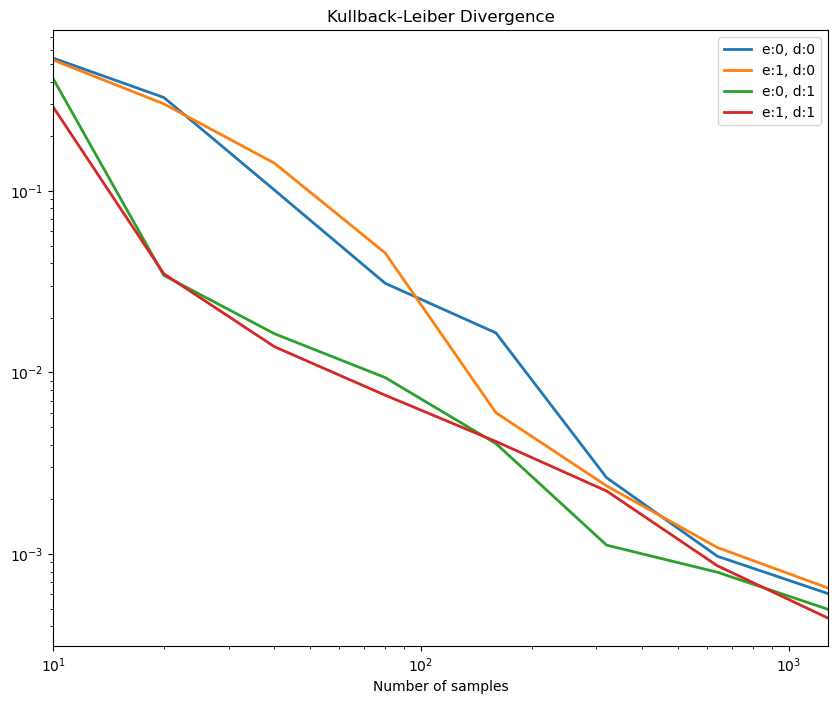

In [33]:
from utils import approx_error

_A_, _B_, _C_, _D_, _E_ = 0, 1, 2, 3, 4

A = np.array([0.2, 0.8])
B_A = np.array([[0.9, 0.2], [0.1, 0.8]])
C = np.array([0.9, 0.1])
D_BC = np.array([[[0.1, 0.2], [0.99, 0.8]], [[0.9, 0.8], [0.01, 0.2]]])
E_C = np.array([[0.7, 0.4], [0.3, 0.6]])

ABCDE = A[:, None, None, None, None] * B_A.T[:, :, None, None, None] * C [None, None, :, None, None] \
        * D_BC.transpose(1, 2, 0)[None, :, :, :, None] * E_C.T[None, None, :, None, :]
ADE = ABCDE.sum(axis=(1, 2))
A_DE = ADE / ADE.sum(axis=0)[None, :, :]

np.random.seed(0)
errs = {}
sample_counts = np.array([10, 20, 40, 80, 160 , 320, 640, 1280])

# compute approximation error
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    errs[(d, e)] = approx_error(
        bayes_net,
        gibbs_sampling,  
        A_DE[:, d, e],
        _A_,
        {_D_:d, _E_:e}, 
        sample_counts,
        n_runs=100,
        burn_in_samples=0,
        sample_distance=1
    )

# plot
plt.figure(figsize=(10, 8))
plt.title('Kullback-Leiber Divergence')
for d, e in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    plt.plot(sample_counts, errs[(d, e)], label=f'e:{e}, d:{d}', lw=2)
    
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(sample_counts.min(), sample_counts.max())
plt.xlabel('Number of samples')
plt.show()

<div class="alert alert-warning">
Answer the following question. Keep your answer <b>concise</b>! (1 point)
</div>

Given the Bayesian Network from the example above, we want to approximate the probabilistic query $P(A \mid D=1, E=1)$. Consider the two cases:

* (1): We draw 100 samples from our implemented ```sample_gibbs``` function. 
* (2): We draw a total of 100 samples from our implemented ```sample_gibbs``` function. However, we start drawing samples only after we have performed 100 Gibbs Sampling steps, and we only take every 10th sample afterwards.

We approximate the result of the probabilistic query with the 100 samples drawn for each of the two scenarios (1) and (2). For which scenario do you expect the smaller approximation error? Explain why!

**Hint**: Use the code cell below to perform whatever analysis supports your answer. You can, for example, use the ```approx_error``` function (used to create the plot above) and experiment with the parameters ```burn_in_samples``` and ```sample_distance```. 

**Note**: Only your textual answer will be graded. The code cell only allows you to check if your intuition is correct.

In [35]:
# You can freely use this code cell to support your answer to the question.

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

YOUR ANSWER HERE

in my opinion scenarion 2 will have smaller approximation error, because of the gipps samles correlation that allows the estimation procces to move closer to the real value redusing the bias also subsampling that reduces autocorrelation between samples so increases the accuracy.

<div class="alert alert-warning">
Answer the following question. Keep your answer <b>concise</b>! (2 point)
</div>

Consider the Bayesian Network below consisting of three binary variables, $C_1$, $C_2$, and $Z$. $C_1$ and $C_2$ are two uniformly distributed, independent coins. $Z$ is the Exclusive OR applied to the outcome of $C_1$ and $C_2$. Can we successfully estimate the probabilistic query $P(C_1, C_2 \mid Z=1)$ using Gibbs Sampling? <b>Justify your answer!</b>
  
**Hint**: Use the code cell below to perform whatever analysis supports your answer. You may want to create the Bayesian Network defined below and pass it to your implemented ```sample_gibbs``` function. Look at the samples generated. Do you see a pattern?

**Note**: Only your textual answer will be graded. However, the code cell allows you to check if your explanation is correct.

<img width='30%' src='img/xor.png'>

<table style="float: left;margin:5px;"><tr><th>P(C1)</th><th>$\neg$$c_1$<br></th><th>$c_1$</th></tr><tr><td>-</td><td>0.5</td><td>0.5</td></tr></table>

<table style="float: left;margin:5px;"><tr><th>P(C2)</th><th>$\neg$$c_2$<br></th><th>$c_2$</th></tr><tr><td>-</td><td>0.5</td><td>0.5</td></tr></table>

<br><br><br>

<table style="float: left;margin:5px;"><tr><th rowspan="2">P($Z$ | $C_1$, $C_2$)</th><th colspan="2">$\neg$$c_1$<br></th><th colspan="2">$c_1$</th></tr><tr><td>$\neg$ c_2</td><td>c_2</td><td>$\neg$ c_2</td><td>c_2</td></tr><tr><td>$\neg$ z<br></td><td>1</td><td>0</td><td>0</td><td>1</td></tr><tr><td>z</td><td>0</td><td>1</td><td>1</td><td>0</td></tr></table>

In [ ]:
# You can freely use this code cell to support your answer to the question.

# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

no it will not be able to estimate  it because when we fix  C1 we only have one posible value of C2 and if we fix C2 we also have only ne possibLe value for C1 so it will not lead to a meaningfull result.